In [1]:
import pandas as pd
test_file_path = r"D:\Capstone projects\Microsoft SCO\GUIDE_Test.csv"
df_test = pd.read_csv(test_file_path)

C:\Users\deepa\AppData\Local\Temp\ipykernel_18532\3950093167.py:3: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv(test_file_path)


In [2]:
df_test.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City', 'Usage'],
      dtype='object')

In [3]:
# List of columns to remove
columns_to_remove = ['Id','OrgId','MitreTechniques','ActionGrouped','ActionGranular','EmailClusterId',
                     'ThreatFamily','ResourceType','Roles','AntispamDirection','SuspicionLevel',
                     'LastVerdict','FolderPath','ApplicationId','RegistryValueName']

df_test.drop(columns=columns_to_remove, inplace=True)

In [4]:
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'])
df_test['hour'] = df_test['Timestamp'].dt.hour
df_test['day_of_week'] = df_test['Timestamp'].dt.dayofweek
df_test.drop(columns=['Timestamp'], inplace=True)

In [5]:
df_test.dropna(axis=0,inplace=True)

In [6]:
# Assuming df is your DataFrame and cat is the list of categorical columns
cat = ['City', 'State', 'CountryCode', 'DeviceName', 'AccountName', 'Url', 'IpAddress', 
       'EvidenceRole', 'EntityType', 'IncidentGrade', 'Category','FileName',
       'OSVersion','OAuthApplicationId','AlertTitle','DeviceId',
       'NetworkMessageId','RegistryValueData','ApplicationName','Sha256',
       'ResourceIdName','OSFamily','Usage']

# Convert columns to category dtype
for column in cat:
    df_test[column] = df_test[column].astype(str)

In [7]:
# Define a function to simplify categories
def simplify_categories(df_test, column, top_n=5):
    top_categories = df_test[column].value_counts().nlargest(top_n).index
    df_test[column] = df_test[column].apply(lambda x: x if x in top_categories else 'Others')

# Apply the function to each categorical column
for column in cat:
    simplify_categories(df_test, column)

In [8]:
df_test.head()

,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,...,FileName,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Usage,hour,day_of_week
0,11767,87199,524,Others,Others,BenignPositive,User,Impacted,98799,138268,...,289573,3586,5,66,242,1445,10630,Private,22,1
1,91158,632273,2,2,CommandAndControl,BenignPositive,Machine,Impacted,Others,138268,...,289573,3586,0,0,242,1445,10630,Public,12,0
2,32247,131719,2932,Others,Others,BenignPositive,Others,Related,98799,Others,...,Others,3586,5,66,242,1445,10630,Public,3,5
3,15294,917686,0,0,InitialAccess,FalsePositive,Others,Related,98799,138268,...,289573,3586,5,66,242,1445,10630,Public,12,2
4,7615,5944,27,Others,Others,BenignPositive,User,Impacted,98799,138268,...,289573,3586,5,66,242,1445,10630,Public,17,3


In [9]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Encode each categorical column
for column in cat:
    df_test[column] = le.fit_transform(df_test[column])

In [10]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df_test.drop(columns=['IncidentGrade'])  # Features
y = df_test['IncidentGrade']  # Target

# Stratified Train-Validation Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
print("Training Set Shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing Set Shape (X_test, y_test):", X_test.shape, y_test.shape)

# Check the class distribution in the training and testing sets
print("\nClass Distribution in Training Set:")
print(y_train.value_counts())

print("\nClass Distribution in Testing Set:")
print(y_test.value_counts())

Training Set Shape (X_train, y_train): (3318393, 31) (3318393,)
Testing Set Shape (X_test, y_test): (829599, 31) (829599,)

Class Distribution in Training Set:
IncidentGrade
0    1402352
2    1193883
1     722158
Name: count, dtype: int64

Class Distribution in Testing Set:
IncidentGrade
0    350588
2    298471
1    180540
Name: count, dtype: int64


In [12]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Initialize the XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss'
)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
macro_f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')
precision_xgb = precision_score(y_test, y_pred_xgb, average='macro')
recall_xgb = recall_score(y_test, y_pred_xgb, average='macro')

# Print the evaluation metrics
print("XGBoost Model Performance:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Macro F1 Score: {macro_f1_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")

XGBoost Model Performance:
Accuracy: 0.8646
Macro F1 Score: 0.8613
Precision: 0.8981
Recall: 0.8436


In [13]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils import resample

# Downsample the training data (20% of the original training set)
X_train_sample, y_train_sample = resample(X_train, y_train, replace=False, n_samples=int(0.2 * len(X_train)), random_state=42)

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3]
}

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')

# Set up HalvingRandomSearchCV
halving_search = HalvingRandomSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    factor=2,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the HalvingRandomSearchCV
halving_search.fit(X_train_sample, y_train_sample)

# Get the best model and parameters
best_model = halving_search.best_estimator_
best_params = halving_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the tuned model on the test data
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
macro_f1_best = f1_score(y_test, y_pred_best, average='macro')
precision_best = precision_score(y_test, y_pred_best, average='macro')
recall_best = recall_score(y_test, y_pred_best, average='macro')

# Print the evaluation metrics
print("\nTuned XGBoost Model Performance:")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"Macro F1 Score: {macro_f1_best:.4f}")
print(f"Precision: {precision_best:.4f}")
print(f"Recall: {recall_best:.4f}")


n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 16
min_resources_: 18
max_resources_: 663678
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 192
n_resources: 18
Fitting 3 folds for each of 192 candidates, totalling 576 fits


C:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 192 is smaller than n_iter=36871. Running 192 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 1
n_candidates: 96
n_resources: 36
Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 2
n_candidates: 48
n_resources: 72
Fitting 3 folds for each of 48 candidates, totalling 144 fits


C:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 3
n_candidates: 24
n_resources: 144
Fitting 3 folds for each of 24 candidates, totalling 72 fits


C:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 4
n_candidates: 12
n_resources: 288
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 5
n_candidates: 6
n_resources: 576
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 6
n_candidates: 3
n_resources: 1152
Fitting 3 folds for each of 3 candidates, totalling 9 fits


C:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 7
n_candidates: 2
n_resources: 2304
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}

Tuned XGBoost Model Performance:
Accuracy: 0.8483
Macro F1 Score: 0.8427
Precision: 0.8897
Recall: 0.8223


In [14]:
# %reset -f

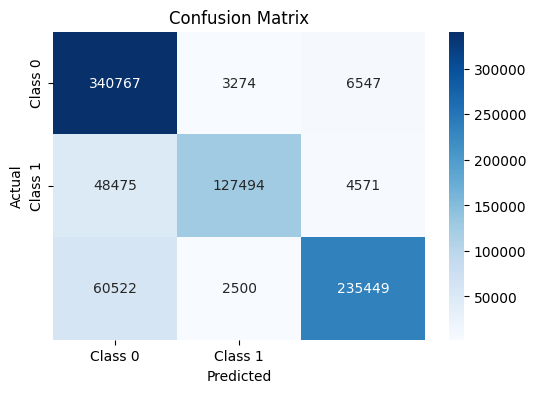

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(y_test, y_pred_best, average='macro')
recall = recall_score(y_test, y_pred_best, average='macro')
f1 = f1_score(y_test, y_pred_best, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8897
Recall: 0.8223
F1 Score: 0.8427


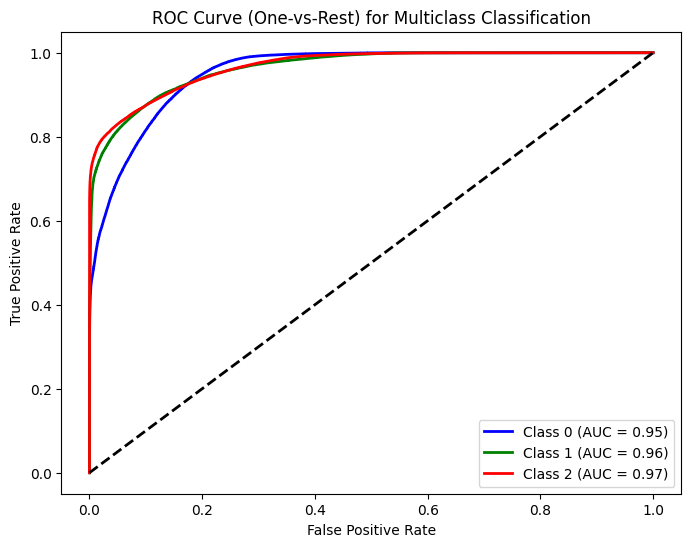

Class 0 AUC: 0.9537
Class 1 AUC: 0.9638
Class 2 AUC: 0.9669


In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output labels (this converts the labels to a one-vs-rest format)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Adjust classes according to your problem
y_pred_proba = best_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']  # Use appropriate colors for your classes

for i, color in zip(range(y_test_bin.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest) for Multiclass Classification')
plt.legend(loc='lower right')
plt.show()

# Print AUC values for each class
for i in range(y_test_bin.shape[1]):
    print(f"Class {i} AUC: {roc_auc[i]:.4f}")

In [20]:
print(classification_report(y_test, y_pred_best, target_names=['TP', 'BP', 'FP']))

              precision    recall  f1-score   support

          TP       0.76      0.97      0.85    350588
          BP       0.96      0.71      0.81    180540
          FP       0.95      0.79      0.86    298471

    accuracy                           0.85    829599
   macro avg       0.89      0.82      0.84    829599
weighted avg       0.87      0.85      0.85    829599

